# Trabajo Práctico 3 de Visión por Computadora I
## Laboratorio de Sistemas Embebidos - FIUBA
## Integrantes:
- Federico Arias
- Hernán Matías Silva

In [1]:
#Importamos librerias
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from glob import glob

Shape del template: (175, 400, 3)


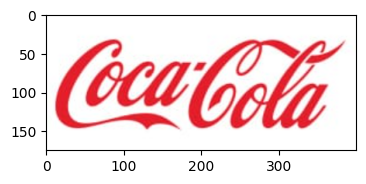

In [2]:
#Leemos el template:
template = cv.imread('template/pattern.png')
#Pasamos a RGB
template_rgb = cv.cvtColor(template, cv.COLOR_BGR2RGB)

#Veamos el template
plt.figure(figsize=(4,3))
plt.imshow(template_rgb)

print('Shape del template:', template_rgb.shape)

In [3]:
#Obtenemos la imagen en gray_scale:
template_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
h_template, w_template = template_gray.shape

In [4]:
#Leemos las imagenes
folder_path = "images/"
image_extensions = ["*.png", "*.jpg"]

image_paths = []
for ext in image_extensions:
    image_paths.extend(glob(os.path.join(folder_path, ext)))

# Cargamos las imágenes en una lista
images = [cv.imread(image_path) for image_path in image_paths]

#Pasamos a colores para posteriormente dibujar el bounding box sobre la imagen a color:
images_rgb = [cv.cvtColor(image, cv.COLOR_BGR2RGB) for image in images]

#Para el template matching debemos cambiar la imagen a escala de grises:
gray_images = [cv.cvtColor(i, cv.COLOR_BGR2GRAY) for i in images]


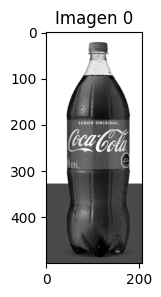

In [8]:
#Veamos alguna:
def plot_image(i):
    plt.figure(figsize=(4,3))
    plt.imshow(gray_images[i], cmap='gray')
    plt.title(f'Imagen {int(i)}')
plot_image(0)

<h2 style='color:orange'>1.- Obtener una deteccion del logo en cada imagen sin falsos positivos</h2>

Para este punto usaremos la funcion de open cv *matchTemplate* para comparar el template y cada imagen.

Como existe variación de escala en las imágenes, vamos a generar pirámides laplacianas y comparar versiones del template vs. versiones de las imagenes.

In [9]:
#Creamos una funcion que devuelva una lista de imagenes de priamide laplaciana
def get_laplacian_pyramid_images_list(img, new_h, new_w):
    '''Img: imagen en gray_scale'''
    img = cv.resize(img, (new_w, new_h))
    gaussian_pyramid = [img]
    for i in range(4):  # Número de niveles de la pirámide
        img = cv.pyrDown(img)
        gaussian_pyramid.append(img)

    # Generamos la pirámide laplaciana
    laplacian_pyramid_template = []
    for i in range(4, 0, -1):
        gaussian_expanded = cv.pyrUp(gaussian_pyramid[i])            
        if gaussian_expanded.shape != gaussian_pyramid[i-1].shape:
            # Si los shapes no coinciden no se puede hacer la comparacion, asi que ajustamos
            #print('shapes distintos')
            gaussian_expanded = cv.resize(gaussian_expanded, (gaussian_pyramid[i-1].shape[1], gaussian_pyramid[i-1].shape[0]))

        #Restamos la gaussiana anterior a la expandida
        laplacian = cv.subtract(gaussian_pyramid[i-1], gaussian_expanded)
        laplacian_pyramid_template.append(laplacian) #Agregamos a la lista

    return laplacian_pyramid_template

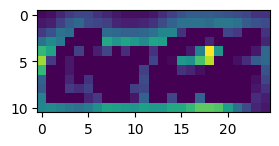

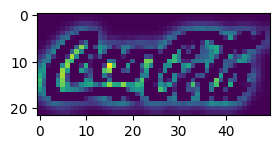

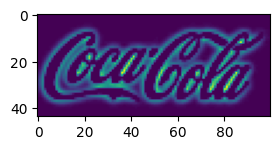

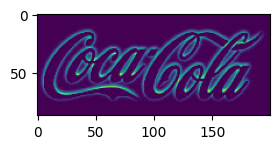

In [11]:
#Generamos la lista de templates laplacianos 
laplacian_pyramid_template = get_laplacian_pyramid_images_list(template_gray, int(h_template*0.5), int(w_template*0.5))

#Graficamos cada una:
for i, laplacian in enumerate(laplacian_pyramid_template):
    plt.figure(figsize=(3,2))
    plt.imshow(laplacian)
    plt.show()


In [12]:
#Generamos las piramides laplacianas de cada imagen en la carpeta images
# y las guardamos en una lista
laplacian_images = []
for image in gray_images:
    laplacian_images.append(get_laplacian_pyramid_images_list(image, new_h=image.shape[0], new_w=image.shape[1]))

En la siguiente seccion se definen funciones para:
- Encontrar el mejor match entre las distintas templates laplacianos vs. versiones laplacianas de cada imagen.
- Se itera sobre cada template variando la escala.

Se dibuja el bounding box para el mejor match.

In [14]:
# Función para redimensionar el template
def resize_template(template, scale):
    new_h = int(template.shape[0] * scale)
    new_w = int(template.shape[1] * scale)
    resized_template = cv.resize(template, (new_w, new_h))
    return resized_template, new_h, new_w

# Función para realizar la búsqueda de template en una imagen
def find_template_in_image(template, image, new_h, new_w, color_image, draw=False):
    '''
    template: template
    image: imagen en la cual se busca el template
    new_w: width del template para buscar dentro de la imagen
    new_h: height del template para buscar dentro de la imagen
    color_image: imagen a color en la cual se busca el template
    draw: bool para dibujar el bounding box sobre la imagen a color'''

    template_resized = cv.resize(template, (new_w, new_h))
    
    result = cv.matchTemplate(template_resized, image, cv.TM_CCORR_NORMED) #Se probaron distintas metricas y esta funciono mejor
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)

    if draw:
        print('Max result:', np.max(result))
        # Dibujamos el bounding box en la mejor coincidencia
        top_left = max_loc
        bottom_right = (top_left[0] + new_w, top_left[1] + new_h)
        cv.rectangle(color_image, top_left, bottom_right, (255, 255, 0), 2)

        # Añadimos el valor máximo en la imagen
        text_position = (10, 30)
        cv.putText(color_image, f'Max: {max_val:.2f}', text_position, 
                   fontFace=cv.FONT_HERSHEY_SIMPLEX, 
                   fontScale=1, color=(0, 0, 0), 
                   thickness=2, lineType=cv.LINE_AA)

        # Mostrar el resultado
        plt.imshow(color_image) 
        plt.show()
    
    return max_val

# Función principal para iterar sobre las escalas y encontrar la mejor coincidencia
def search_best_scale(template, image, scales, color_image, draw=True, threshold=0.31):
    best_val = 0
    best_h, best_w = 0, 0
    for scale in scales:
        try:
            # Redimensionamos template a la escala dada como argumento de la funcion
            resized_template, new_h, new_w = resize_template(template, scale)
            
            # Buscar la coincidencia en la imagen
            max_val = find_template_in_image(template, image, new_h, new_w, color_image.copy(), draw=False)
            
            # Verificar si es la mejor coincidencia hasta ahora
            if max_val > best_val:
                best_val = max_val
                best_h, best_w = new_h, new_w
                
        except Exception as e:
            '''Cuando el template es mas grande que la imagen, da error'''
            pass
    
    # Dibujar el mejor resultado de la busqueda
    if best_val > threshold:
        find_template_in_image(template, image, new_h=best_h, new_w=best_w, color_image=color_image.copy(), draw=draw)
    else:
        print('No se encontró coincidencia satisfactoria.')
    
    return best_val

In [15]:
#Iteramos varias veces y el mejor template laplaciano fue el penultimo:
template_laplaciano = laplacian_pyramid_template[3]

Max result: 0.45316413


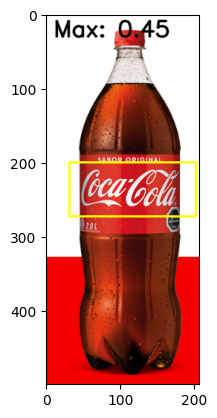

Max result: 0.32367834


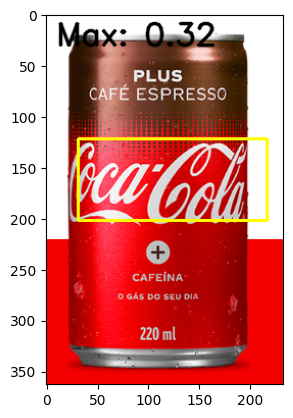

Max result: 0.3407618


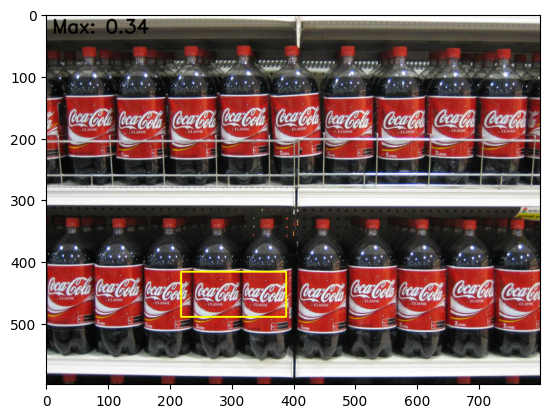

Max result: 0.39629656


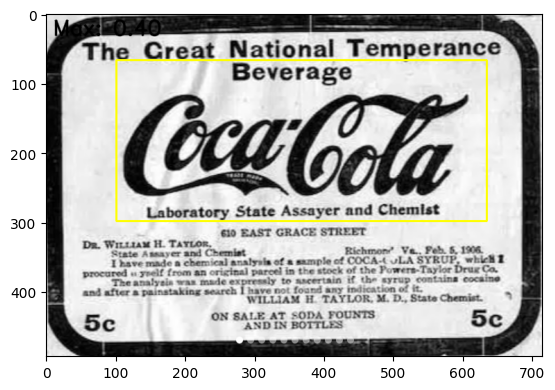

Max result: 0.4434451


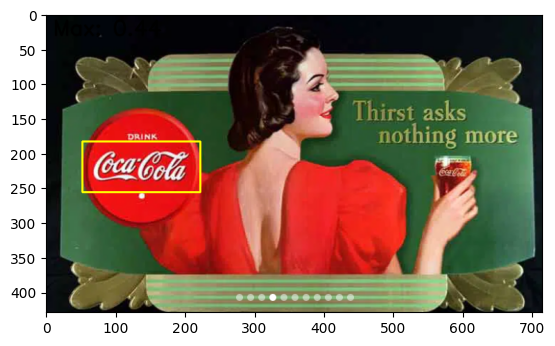

Max result: 0.385766


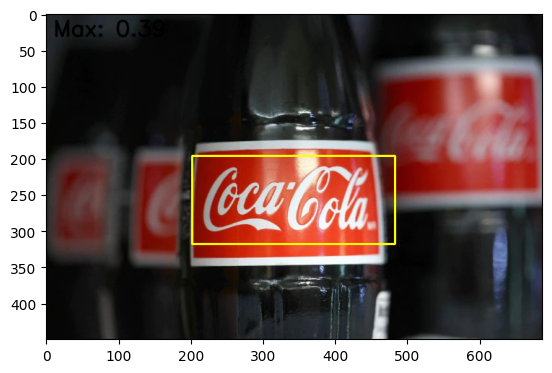

Max result: 0.4333832


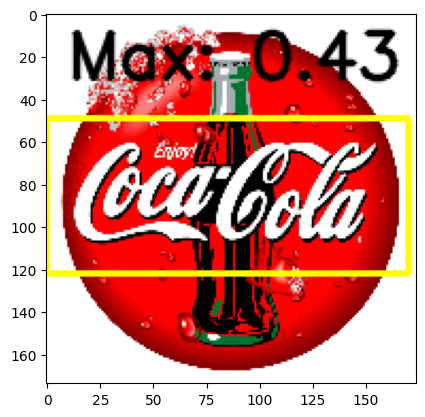

In [16]:
#Definimos unas escalas para iterar sobre ellas
scales = np.linspace(0.85, 3.15, 30)

for i in range(0, len(laplacian_images)):
    imagen_1 = laplacian_images[i][3].copy()  # Definimos la version de la piramide laplaciana 
    if (imagen_1.shape[0] < 10*template_laplaciano.shape[0]) :
        '''Si la imagen es 10 veces mas alta que el template, 
        cambiamos de version de laplace de la imagen, e iteramos en el else de abajo'''
        search_best_scale(template_laplaciano, imagen_1, scales, images_rgb[i], draw=True)
    else:
        '''Vamos a iterar entre las distintas versiones de la piramide laplaciana de la imagen
        y vamos a dibujar el bounding box para aquella con el mejor valor de match'''
        best_val = 0
        for j in range(0, len(laplacian_images[i])):
            imagen_1 = laplacian_images[i][j].copy() 
            #Hacemos resize de la imagen original para que el bb corresponda con la roi del match
            image_to_draw = cv.resize(images_rgb[i], (imagen_1.shape[0], imagen_1.shape[1]))
            #Corremos el match y guardamos el valor de match para compararlo con la siguiente iteracion
            new_best_val = search_best_scale(template_laplaciano, imagen_1, scales, image_to_draw, draw=False)
            if new_best_val > best_val:
                best_val = new_best_val
                best_template = j
        #Dibujamos la imagen con el bb con el mejor match
        imagen_1 = laplacian_images[i][best_template].copy() 
        image_to_draw = cv.resize(images_rgb[i], (imagen_1.shape[0], imagen_1.shape[1]))
        new_best_val = search_best_scale(template_laplaciano, imagen_1, scales, image_to_draw, draw=True)

<h2 style='color:orange'>2.- Plantear y validar un algoritmo para multiples detecciones en la imagen `coca_multi.png` con el mismo template</h2>

In [69]:
# Aca vamos a definir un loop que compare distintos templates derivados de la piramide 
# laplaciana del template vs distintas versiones de la imagen derivadas de la imagen a coca_multi

#copiamos la version de coca cola multi de la escala de grises
coca_multi = gray_images[2]

coca_h = coca_multi.shape[0]
coca_w = coca_multi.shape[1]

#Obtenemos las laplacianas de la imagen:
laplacian_coca_multi = get_laplacian_pyramid_images_list(coca_multi, new_h=coca_h, new_w=coca_w)
len(laplacian_coca_multi)

4

Text(0.5, 1.0, 'Imagen en color')

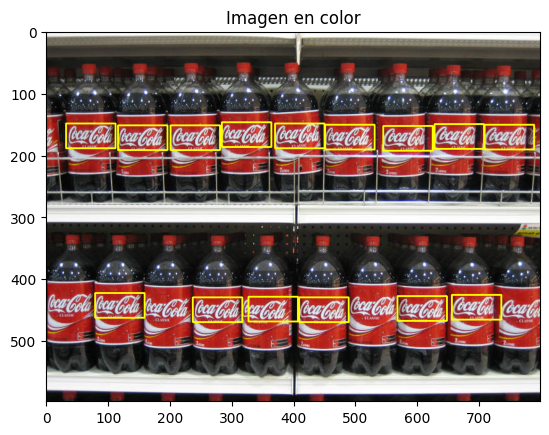

In [70]:
'''Intentamos comparando cada template laplaciano con cada imagen derivada de 
la piramide laplaciana de coca_multi en dos bucles anidados.
Nos dimos cuenta que el que mejores match hacia son los de mejor definicion,
asi solo usamos esos dos.
Tambien nos dimos cuenta que cuando le dibujamos el bounding box, esa ya no es el
mismo siguiente match, porque el bb edita la imagen original,
entonces el algoritmo encuentra otro match, asi que usamos un bucle simple tal que corra
siempre y cuando cada comparacion supere un threshold.'''

threshold = 0.36
template_laplaciano_resized = cv.resize(laplacian_pyramid_template[3], (80, 40))

#Transformamos la imagen coca multi a grayscale:
coca_multi_rgb = images_rgb[2]

#Obtenemos el shape de la imagen y se los asignamos a la imagen a color
# para poder dibujar la imagen a color con los
# bounding boxes
new_h, new_w = laplacian_coca_multi[3].shape
coca_multi_rgb_resized = cv.resize(coca_multi_rgb, (new_w, new_h))  

for i in range(0, 15):
    result = cv.matchTemplate(template_laplaciano_resized, laplacian_coca_multi[3], cv.TM_CCORR_NORMED)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)
    max_result = max_val

    if max_val > threshold:
        #print(max_val)
        # Dibujar el bounding box en ambas imágenes
        w, h = template_laplaciano_resized.shape[::-1]
        top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)

        #print(f"Top left: {top_left}, Bottom right: {bottom_right}")

        # Dibujar el bounding box en la imagen en escala de grises
        cv.rectangle(laplacian_coca_multi[3], top_left, bottom_right, (255, 255, 0), 2)
        
        # Dibujar el bounding box en la imagen a color (usando rojo para asegurarnos de que sea visible)
        cv.rectangle(coca_multi_rgb_resized, top_left, bottom_right, (255, 255, 0), 2)

# Mostrar el resultado
plt.imshow(coca_multi_rgb_resized)
plt.title('Imagen en color')


## Parte 3

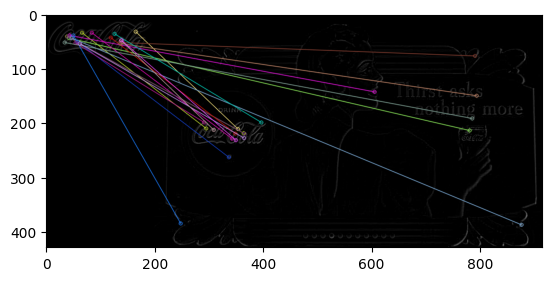

In [153]:
import cv2

sift = cv2.ORB_create()

logo_img = laplacian_pyramid_template[3]
target_img = laplacian_images[4][3]

# Detectar puntos clave y descriptores en ambas imágenes
keypoints_logo, descriptors_logo = sift.detectAndCompute(logo_img, None)
keypoints_target, descriptors_target = sift.detectAndCompute(target_img, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)  # crossCheck asegura coincidencias más precisas
matches = bf.match(descriptors_logo, descriptors_target)

# Ordenar las coincidencias por la distancia (las mejores coincidencias primero)
matches = sorted(matches, key=lambda x: x.distance)

# Dibujar las coincidencias (opcional, para visualización)
matched_img = cv2.drawMatches(logo_img, keypoints_logo, target_img, 
                              keypoints_target, matches[:19], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(matched_img)


In [156]:
# Filtrar las mejores coincidencias (puedes ajustar este umbral)
good_matches = matches[:20]

# Obtener los puntos clave correspondientes en ambas imágenes
src_pts = np.float32([keypoints_logo[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints_target[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Aplicar la homografía si se encuentran suficientes buenos matches
if len(good_matches) > 10:  # Requiere al menos 10 buenos matches para una homografía confiable
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 10.0)

    # Obtener el tamaño del logo
    h, w = logo_img.shape

    # Definir los puntos de los bordes del logo en la imagen original
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

    # Aplicar la transformación de homografía para encontrar los puntos en la imagen objetivo
    dst = cv2.perspectiveTransform(pts, M)

    # Dibujar los bordes del logo encontrado en la imagen objetivo
    target_img_with_logo = cv2.polylines(target_img.copy(), [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

    # Mostrar la imagen con la detección del logo
    cv2.imshow("Detección del logo", target_img_with_logo)
    cv2.waitKey(0)
